In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from tqdm import tqdm

from vae import VariationalAutoencoder
from modules import train_epoch, test_epoch, plot_ae_outputs

/home/szaryvip/INZ/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [3]:
import torch.nn.functional as F
def sobel(tensor_image):
    tensor_image = tensor_image.unsqueeze(0)
    # Define the Sobel filter kernels
    sobel_x = torch.tensor([[1/8, 0, -1/8], [2/8, 0, -2/8], [1/8, 0, -1/8]], dtype=torch.float32)
    sobel_y = torch.tensor([[1/8, 2/8, 1/8], [0, 0, 0], [-1/8, -2/8, -1/8]], dtype=torch.float32)

    # Add a batch and channel dimension to the kernels
    sobel_x = sobel_x.unsqueeze(0).unsqueeze(0).expand(1, 3, 3, 3)
    sobel_y = sobel_y.unsqueeze(0).unsqueeze(0).expand(1, 3, 3, 3)

    # Apply the Sobel filters to the image
    gradient_x = F.conv2d(tensor_image, sobel_x, padding=1)
    gradient_y = F.conv2d(tensor_image, sobel_y, padding=1)

    # Compute the magnitude of the gradients
    gradient_magnitude = torch.sqrt(gradient_x**2 + gradient_y**2)
    return gradient_magnitude.squeeze()

In [4]:
# mnist_trainset = torchvision.datasets.MNIST(root="../datasets/", train=True, download=True, transform=None)
# mnist_testset = torchvision.datasets.MNIST(root="../datasets/", train=False, download=True, transform=None)

mnist_trainset = torchvision.datasets.CIFAR10(root="../datasets/", train=True, download=True, transform=None)
mnist_testset = torchvision.datasets.CIFAR10(root="../datasets/", train=False, download=True, transform=None)

# mnist_trainset = torchvision.datasets.CIFAR100(root="../datasets/", train=True, download=True, transform=None)
# mnist_testset = torchvision.datasets.CIFAR100(root="../datasets/", train=False, download=True, transform=None)

batch_size=128
m=len(mnist_trainset)
mean_cifar, std_cifar = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Grayscale()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Grayscale()
])

mnist_trainset.transform = train_transform
mnist_testset.transform = test_transform

mnist_trainset, val_data = random_split(mnist_trainset, [int(m-m*0.2), int(m*0.2)])
# mnist_testset = [(sobel(data[0]), data[1]) for data in mnist_testset]
# val_data = [(sobel(data[0]), data[1]) for data in val_data]
# mnist_trainset = [(sobel(data[0]), data[1]) for data in mnist_trainset]


train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


What | MNIST | MNIST | MNIST || CIFAR10 | CIFAR10 | CIFAR10 || CIFAR100:

d | 4 is okey | 128 | 64 || 128 | 64 | 32 || 64

loss 25 epochs | (10 epochs) 21 | 2.5 | 2.6 || 36.5 | 35.2 | 42.1 || 35.5

lr 1e-3

optim Adam


In [5]:
d = 64
lr = 1e-3
vae = VariationalAutoencoder(len(mnist_trainset[0][0]), latent_dims=d, device=device)
mono_iter = len(mnist_trainset)/batch_size*4
vae.set_monotonic_iterations(mono_iter)
vae.to(device)
# torch.nn.init.xavier_normal_

optim = torch.optim.Adam(vae.parameters(), lr=lr)

In [6]:
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   
   print("BETA: ", vae.encoder.i/mono_iter, "KL: ", vae.encoder.kl)
   train_losses.append(train_loss)
   val_losses.append(val_loss)


 EPOCH 1/20 	 train loss 101.863 	 val loss 65.196
BETA:  0.3768 KL:  tensor(30.9956, device='cuda:0')

 EPOCH 2/20 	 train loss 58.401 	 val loss 53.834
BETA:  0.7536 KL:  tensor(28.3060, device='cuda:0')

 EPOCH 3/20 	 train loss 50.701 	 val loss 48.589
BETA:  1.0 KL:  tensor(25.0050, device='cuda:0')

 EPOCH 4/20 	 train loss 45.837 	 val loss 44.724
BETA:  1.0 KL:  tensor(20.2881, device='cuda:0')

 EPOCH 5/20 	 train loss 42.807 	 val loss 42.541
BETA:  1.0 KL:  tensor(17.9466, device='cuda:0')

 EPOCH 6/20 	 train loss 40.379 	 val loss 40.498
BETA:  0.2608 KL:  tensor(7.0196, device='cuda:0')

 EPOCH 7/20 	 train loss 38.798 	 val loss 39.549
BETA:  0.6376 KL:  tensor(15.4112, device='cuda:0')

 EPOCH 8/20 	 train loss 37.811 	 val loss 39.367
BETA:  1.0 KL:  tensor(18.2993, device='cuda:0')

 EPOCH 9/20 	 train loss 36.885 	 val loss 39.453
BETA:  1.0 KL:  tensor(15.2060, device='cuda:0')

 EPOCH 10/20 	 train loss 36.229 	 val loss 38.560
BETA:  1.0 KL:  tensor(14.1303, devi

im więcej warstw tym znacznie dłuższe uczenie -> potrzeba zaoszczędzenia czasu (efekty podobne a nawet i gorsze po takiej samej ilości epok)

duże znaczenie przestrzeni ukrytej w kolorowych obrazkach (rozmiaru przestrzeni)

spore znaczenie rozmiaru warst gęstych niekonwolucyjnych było 128 tylko, lepsze wyniki przy większych

Znacznie gorsze działanie dla cifara całego algorytmu:

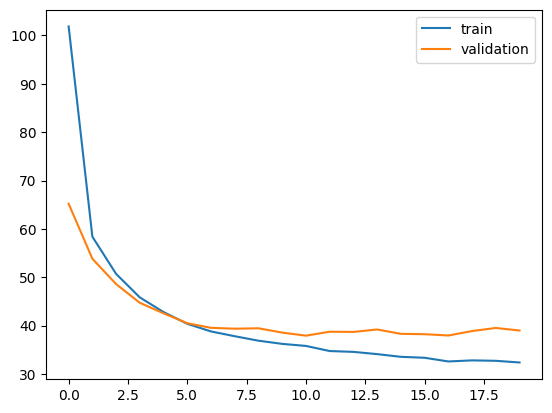

In [7]:
plt.plot(range(num_epochs), train_losses, label="train")
plt.plot(range(num_epochs), val_losses, label="validation")
plt.legend()
plt.show()

In [8]:
import matplotlib.image as mpimg

def denormalize(image):
    means = torch.tensor(mean_cifar).reshape(3,1,1)
    stds = torch.tensor(std_cifar).reshape(3,1,1)
    return image * stds + means
    

def plot_ae_outputs(encoder,decoder,testset,device,n=10,save=False):
    if len(testset[0][0]) == 1:
        plt.figure(figsize=(16,4.5))
        for i in range(n):
            ax = plt.subplot(2,n,i+1)
            img = testset[i][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img), encoder.conv_shape, img.shape[2:])
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('Original images')
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('Reconstructed images')
        if save:
            plt.savefig(f"{n}_recon_mono.png")
        else:
            plt.show()
    else:
        plt.figure(figsize=(16,4.5))
        for i in range(n):
            ax = plt.subplot(2,n,i+1)
            img = testset[i][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img), encoder.conv_shape, img.shape[2:])
            plt.imshow(transforms.ToPILImage()(img.cpu().squeeze()))
            # plt.imshow(transforms.ToPILImage()(denormalize(img.cpu()).squeeze()))
            
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('Original images')
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(transforms.ToPILImage()(rec_img.cpu().squeeze()))  
            # plt.imshow(transforms.ToPILImage()(denormalize(rec_img.cpu()).squeeze()))  
            
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('Reconstructed images')
        if save:
            plt.savefig(f"{n}_recon_color.png")
        else:
            plt.show()

TEST loss:  39.02848073730469


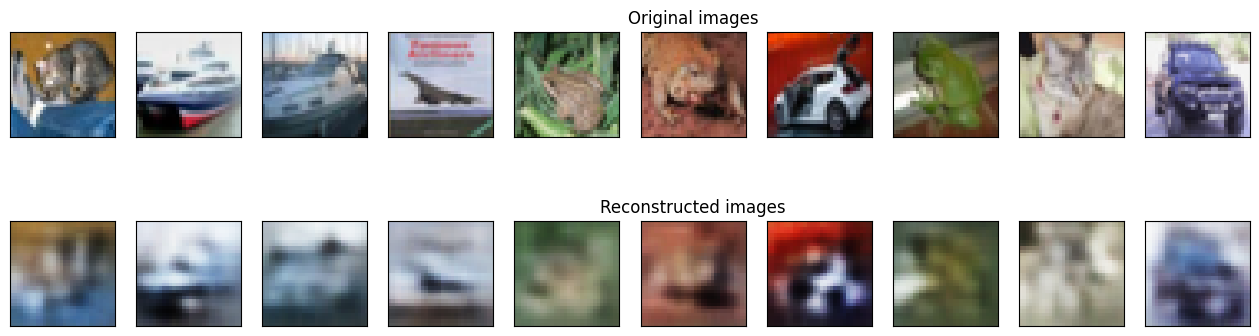

In [9]:
test_loss = test_epoch(vae, device, test_loader)
print("TEST loss: ", test_loss)
plot_ae_outputs(vae.encoder,vae.decoder,mnist_testset,device,n=10, save=True)

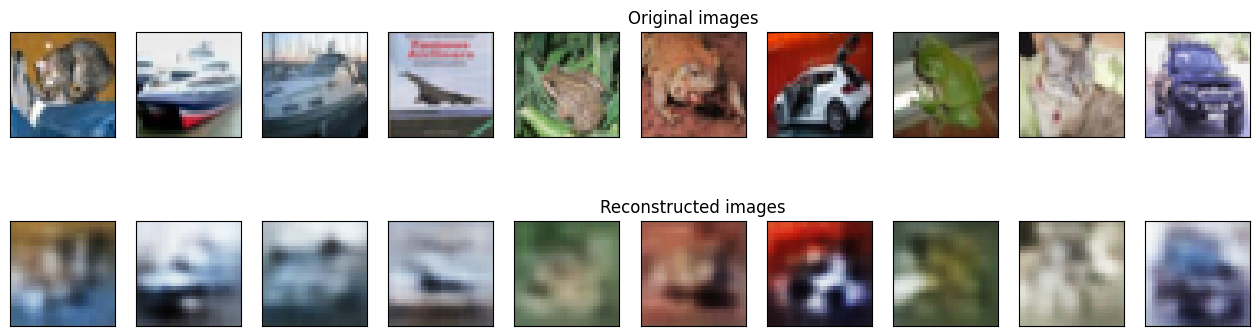

In [10]:
plot_ae_outputs(vae.encoder,vae.decoder,mnist_testset,device,n=10, save=True)

In [11]:
torch.save(vae.state_dict(), "model.pt")

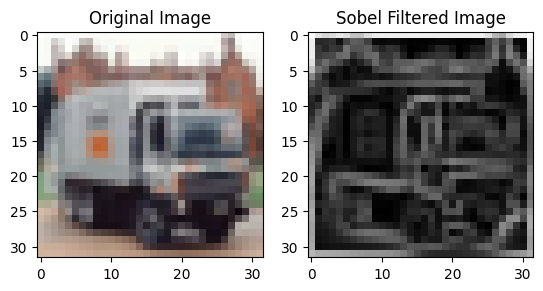

In [12]:
tensor_image = mnist_testset[11][0]  # Add a batch dimension
gradient_magnitude = sobel(tensor_image)


# Display the original image and the filtered image
plt.subplot(1, 2, 1)
plt.imshow(tensor_image.permute(1, 2, 0).numpy())
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(gradient_magnitude.numpy(), cmap='gray')
plt.title('Sobel Filtered Image')

plt.show()

In [13]:
# encoded_samples = []
# for sample in tqdm(mnist_trainset):
#     img = sample[0].unsqueeze(0).to(device)
#     label = sample[1]
#     with torch.no_grad():
#         encoded_img  = vae.encoder(img)
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_samples.append(encoded_sample)

In [14]:
# from sklearn.manifold import TSNE
# encoded_samples = pd.DataFrame(encoded_samples)
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples)

from d | tsne time (10k samples) | 40k samples

32 | 31s | 
64 | 36s | 2m35s,2m31s